In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sb
import scipy.stats as stats

A common critic of macroeconomic modeling is how inaccurate it is when trying to apply it to real world data. Here I am testing the accuracy of the Phillips Curve and how it relates oil price to inflation. Then I will modify it to reduce omitted variable bias and increase its accuracy with the data we see in the real world. Following that I will use ridge regression to combat multicollinearity. Finally I will apply machine learning to create non-linear models.  

Here I combine various datasets from the website FRED into a single data frame that will be used in this project. 

In [3]:
cpi = pd.read_csv('CPIAUCSL.csv')
cpi = cpi.reset_index()
cpi['DATE'] = pd.to_datetime(cpi['DATE'])

exp_inflation_1yr = pd.read_csv('EXPINF1YR.csv')
exp_inflation_1yr['DATE'] = pd.to_datetime(exp_inflation_1yr['DATE'])
exp_inflation_5yr = pd.read_csv('EXPINF5YR.csv')
exp_inflation_5yr['DATE'] = pd.to_datetime(exp_inflation_5yr['DATE'])
exp_inflation_10yr = pd.read_csv('EXPINF10YR.csv')
exp_inflation_10yr['DATE'] = pd.to_datetime(exp_inflation_10yr['DATE'])

unemploy_rate = pd.read_csv('UNRATE.csv')
unemploy_rate['DATE'] = pd.to_datetime(unemploy_rate['DATE'])
noncyclical_unemploy = pd.read_csv('NROU.csv')
noncyclical_unemploy['DATE'] = pd.to_datetime(noncyclical_unemploy['DATE'])

oil_apsp_yearly_percent = pd.read_csv('POILAPSPUSDM(1yr%change).csv')
oil_apsp_yearly_percent['DATE'] = pd.to_datetime(oil_apsp_yearly_percent['DATE'])
oil_bre_yearly_percent = pd.read_csv('POILBREUSDM(1yr%change).csv')
oil_bre_yearly_percent['DATE'] = pd.to_datetime(oil_bre_yearly_percent['DATE'])
oil_dub_yearly_percent = pd.read_csv('POILDUBUSDM(1yr%change).csv')
oil_dub_yearly_percent['DATE'] = pd.to_datetime(oil_dub_yearly_percent['DATE'])
oil_wti_yearly_percent = pd.read_csv('POILWTIUSDM(1yr%change).csv')
oil_wti_yearly_percent['DATE'] = pd.to_datetime(oil_wti_yearly_percent['DATE'])

oil_apsp_monthly_percent = pd.read_csv('POILAPSPUSDM(%change).csv')
oil_apsp_monthly_percent['DATE'] = pd.to_datetime(oil_apsp_monthly_percent['DATE'])
oil_bre_monthly_percent = pd.read_csv('POILBREUSDM(%change).csv')
oil_bre_monthly_percent['DATE'] = pd.to_datetime(oil_bre_monthly_percent['DATE'])
oil_dub_monthly_percent = pd.read_csv('POILDUBUSDM(%change).csv')
oil_dub_monthly_percent['DATE'] = pd.to_datetime(oil_dub_monthly_percent['DATE'])
oil_wti_monthly_percent = pd.read_csv('POILWTIUSDM(%change).csv')
oil_wti_monthly_percent['DATE'] = pd.to_datetime(oil_wti_monthly_percent['DATE'])

EFFECTIVE_ECHANGE_RATE = pd.read_csv('RBUSBIS.csv')
EFFECTIVE_ECHANGE_RATE['DATE'] = pd.to_datetime(EFFECTIVE_ECHANGE_RATE['DATE'])

In [4]:
# Convert quarter to monthly
noncyclical_unemploy['DATE'] = pd.to_datetime(noncyclical_unemploy['DATE'])

# Create a new dataframe for monthly data
noncyclical_unemploy_monthly = pd.DataFrame()

for column,row in noncyclical_unemploy.iterrows():
    monthly_values = pd.DataFrame({
        'DATE': [row.iloc[0],row.iloc[0]+pd.DateOffset(months=int(1)),row.iloc[0]+pd.DateOffset(months=2)],
        'NROU': [row.iloc[1],row.iloc[1],row.iloc[1]]
    })
    noncyclical_unemploy_monthly = pd.concat([noncyclical_unemploy_monthly,monthly_values])

In [5]:
all_frames = [cpi,exp_inflation_1yr,exp_inflation_5yr,exp_inflation_10yr,unemploy_rate,noncyclical_unemploy_monthly,
              oil_apsp_yearly_percent,oil_dub_yearly_percent,oil_wti_yearly_percent,oil_bre_yearly_percent,
              oil_apsp_monthly_percent,oil_dub_monthly_percent,oil_wti_monthly_percent,oil_bre_monthly_percent,EFFECTIVE_ECHANGE_RATE]
df = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='inner'), all_frames)
df = df.set_index('DATE')
df = df.drop('index',axis=1)
df = df.rename(columns={"CPIAUCSL_PC1": "CPI"})
df['UNEMPLOY_GAP'] = df['UNRATE'] - df['NROU']
df

,CPI,EXPINF1YR,EXPINF5YR,EXPINF10YR,UNRATE,NROU,POILAPSPUSDM_PC1,POILDUBUSDM_PC1,POILWTIUSDM_PC1,POILBREUSDM_PC1,POILAPSPUSDM_PCH,POILDUBUSDM_PCH,POILWTIUSDM_PCH,POILBREUSDM_PCH,RBUSBIS_PC1,UNEMPLOY_GAP
DATE,,,,,,,,,,,,,,,,
1995-01-01,2.87081,3.700170,3.909821,3.866640,5.6,5.420172,19.52846,22.39767,19.74056,16.67587,3.97958,3.59989,4.46969,3.81967,-0.74417,0.179828
1995-02-01,2.86299,3.563715,3.798551,3.769067,5.4,5.420172,26.83258,29.80200,25.57651,25.42939,3.40559,3.38282,3.14916,3.70425,-1.06588,-0.020172
1995-03-01,2.78722,3.474127,3.607678,3.576065,5.4,5.420172,28.65517,35.20792,26.52583,25.17445,-0.49883,-1.36032,-0.00844,-0.19963,-2.57078,-0.020172
1995-04-01,3.12500,3.464424,3.562348,3.523141,5.8,5.409451,23.83886,26.39199,20.88425,24.71338,7.41336,6.44099,6.59944,9.20997,-6.33715,0.390549
1995-05-01,3.11864,3.466241,3.393961,3.329650,5.6,5.409451,13.49947,16.91605,10.44010,13.74417,-0.54088,-0.49496,-0.35682,-0.77653,-6.02630,0.190549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,3.25021,2.935668,2.514668,2.451501,4.0,4.414191,11.46096,13.20641,11.55785,9.64591,-6.60428,-6.82677,-6.31524,-6.65430,2.59460,-0.414191
2024-06-01,2.97563,2.725840,2.412285,2.367064,4.1,4.414191,12.24079,12.55588,13.66252,10.59353,-0.29671,-0.65385,-0.05614,-0.16425,3.52448,-0.314191
2024-07-01,2.92357,2.555644,2.393559,2.368186,4.3,4.411415,6.20510,5.64889,8.15815,4.91786,1.72321,1.29446,2.54694,1.36424,3.89684,-0.111415


Here we can see that there are correlations between the various causes of inflation, none can have very strong correlation coefficients and thus cannot be used alone. However, all of them have at least some statistical significance meaning they do have an effect.

In [32]:
r, p = stats.pearsonr(df['POILAPSPUSDM_PC1'], df['CPI'])
print(f"POILAPSPUSDM_PC1 r = {str(round(r,3))}:p={str(round(p,3))}")

r, p = stats.pearsonr(df['UNEMPLOY_GAP'], df['CPI'])
print(f"UNEMPLOY_GAP r = {str(round(r,3))}:p={str(round(p,3))}")

r, p = stats.pearsonr(df['EXPINF1YR'], df['CPI'])
print(f"EXPINF1YR r = {str(round(r,3))}:p={str(round(p,3))}")

r, p = stats.pearsonr(df['RBUSBIS_PC1'], df['CPI'])
print(f"RBUSBIS_PC1 r = {str(round(r,3))}:p={str(round(p,3))}")

POILAPSPUSDM_PC1 r = 0.589:p=0.0
UNEMPLOY_GAP r = -0.373:p=0.0
EXPINF1YR r = 0.558:p=0.0
RBUSBIS_PC1 r = -0.086:p=0.103


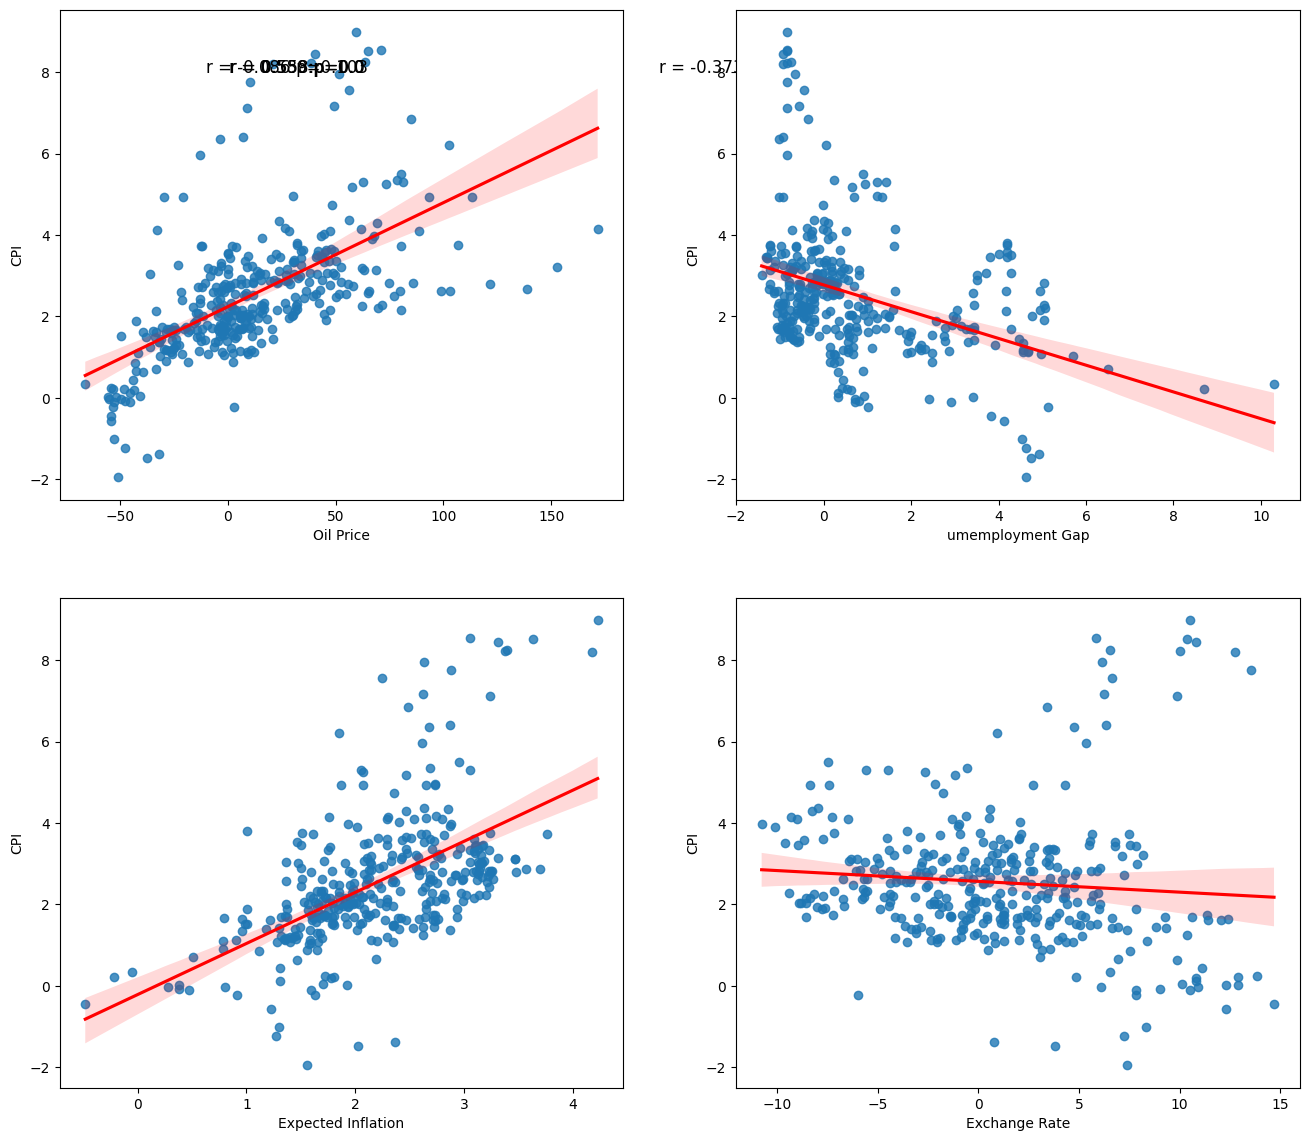

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2)
sb.regplot(x='POILAPSPUSDM_PC1',y='CPI',data=df,ax=ax[0,0],line_kws=dict(color="r"))
ax[0,0].set(xlabel='Oil Price',ylabel='CPI')

sb.regplot(x='UNEMPLOY_GAP',y='CPI',data=df,ax=ax[0,1],line_kws=dict(color="r"))
ax[0,1].set(xlabel='umemployment Gap',ylabel='CPI')

sb.regplot(x='EXPINF1YR',y='CPI',data=df,ax=ax[1,0],line_kws=dict(color="r"))
ax[1,0].set(xlabel='Expected Inflation',ylabel='CPI')

sb.regplot(x='RBUSBIS_PC1',y='CPI',data=df,ax=ax[1,1],line_kws=dict(color="r"))
ax[1,1].set(xlabel='Exchange Rate',ylabel='CPI')

fig.set_figheight(14)
fig.set_figwidth(16)

Lets run a regression using the traditional Phillips curve, that only takes into account inflation expectation and the unemployment gap.

In [50]:
model = smf.ols(formula='CPI ~ EXPINF1YR + UNEMPLOY_GAP', data=df_withrate).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     80.71
Date:                Fri, 18 Oct 2024   Prob (F-statistic):           1.32e-29
Time:                        02:42:53   Log-Likelihood:                -614.45
No. Observations:                 357   AIC:                             1235.
Df Residuals:                     354   BIC:                             1247.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0214      0.305     -0.070   

In [56]:
df['PHILLIP_OG'] = (model.params['Intercept'] +model.params['EXPINF1YR']*df['EXPINF1YR'] + model.params['UNEMPLOY_GAP']*df['UNEMPLOY_GAP'])

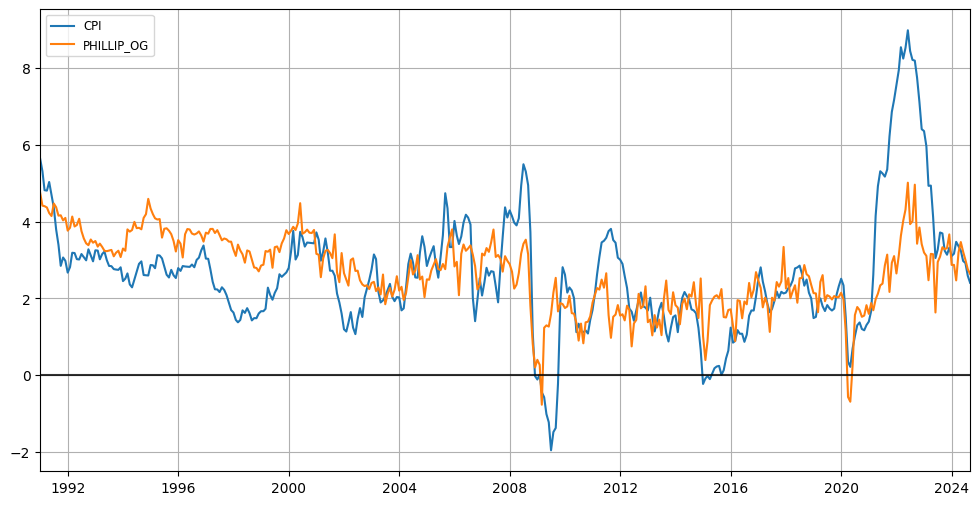

In [57]:
plt.figure(figsize=(12,6))
plt.plot(df.index,df['CPI'],label='CPI')
plt.plot(df.index,df['PHILLIP_OG'],label='PHILLIP_OG')

plt.axhline(y=-0.008, color='black',alpha=0.8)
plt.grid()
plt.legend(fontsize="small",loc="upper left")

plt.margins(x=0)
plt.show()

Here we find that the unemployment gap does have a slight negative relationship with inflation at a signifance level of 33.2 percent, additionally this model seems to fit the data moderatly well with an R-squared value of 0.313. Lets run OLS regression with more modern forms of the phillips curve that capture supply effects.

In [54]:
model2 = smf.ols(formula='CPI ~ EXPINF1YR + UNEMPLOY_GAP + POILAPSPUSDM_PC1', data=df_withrate).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     114.4
Date:                Fri, 18 Oct 2024   Prob (F-statistic):           9.15e-52
Time:                        02:46:07   Log-Likelihood:                -560.27
No. Observations:                 357   AIC:                             1129.
Df Residuals:                     353   BIC:                             1144.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7824      0.272  

In [58]:
df['PHILLIP_OIL'] = (model2.params['Intercept'] + model2.params['EXPINF1YR']*df['EXPINF1YR'] + model2.params['UNEMPLOY_GAP']*df['UNEMPLOY_GAP'] 
    + model2.params['POILAPSPUSDM_PC1']*df['POILAPSPUSDM_PC1'])

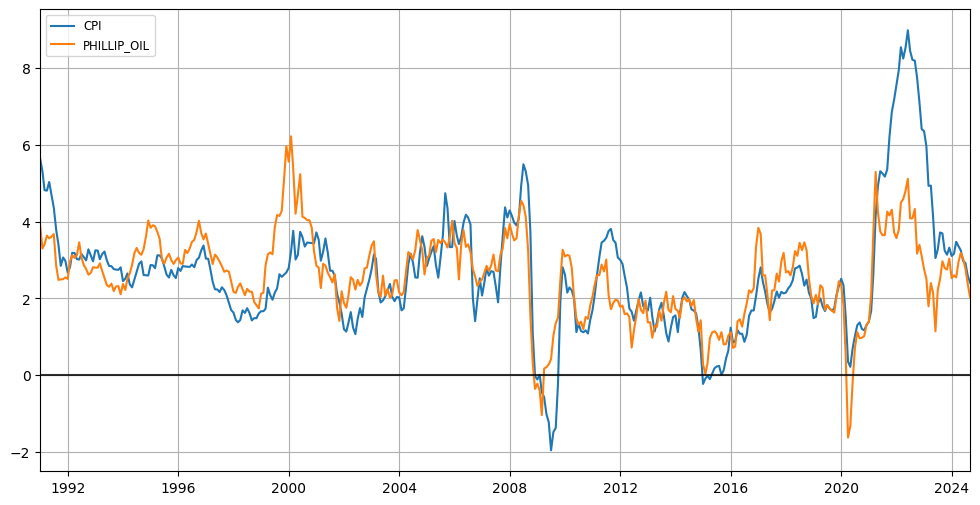

In [59]:
plt.figure(figsize=(12,6))
plt.plot(df.index,df['CPI'],label='CPI')
plt.plot(df.index,df['PHILLIP_OIL'],label='PHILLIP_OIL')

plt.axhline(y=-0.008, color='black',alpha=0.8)
plt.grid()
plt.legend(fontsize="small",loc="upper left")

plt.margins(x=0)
plt.show()

When taking into account the percent change of oil price from the previous year we find that it seems to explain away much of the influence the unemployment gap has on inflation but leads to a more accurate model with a higher R-squared value.

In [61]:
EFFECTIVE_ECHANGE_RATE = pd.read_csv('RBUSBIS.csv')
EFFECTIVE_ECHANGE_RATE['DATE'] = pd.to_datetime(EFFECTIVE_ECHANGE_RATE['DATE'])
df_withrate = df.reset_index().merge(EFFECTIVE_ECHANGE_RATE,how='inner')
df_withrate = df_withrate.set_index('DATE')
#df_withrate = df_withrate.drop('index',axis=1)
df_withrate

,CPI,EXPINF1YR,EXPINF5YR,EXPINF10YR,UNRATE,NROU,POILAPSPUSDM_PC1,POILDUBUSDM_PC1,POILWTIUSDM_PC1,POILBREUSDM_PC1,...,POILWTIUSDM_PCH,POILBREUSDM_PCH,UNEMPLOY_GAP,PHILLIP_EST,PHILLIP_EST_2,adjusted_cpi,og_curve,PHILLIP_OG,PHILLIP_OIL,RBUSBIS_PC1
DATE,,,,,,,,,,,,,,,,,,,,,
1995-01-01,2.87081,3.700170,3.909821,3.866640,5.6,5.420172,19.52846,22.39767,19.74056,16.67587,...,4.46969,3.81967,0.179828,3.997492,4.211081,-0.829360,3.697111,4.345502,3.841211,-0.74417
1995-02-01,2.86299,3.563715,3.798551,3.769067,5.4,5.420172,26.83258,29.80200,25.57651,25.42939,...,3.14916,3.70425,-0.020172,4.036677,4.208217,-0.700725,3.564058,4.193632,3.907839,-1.06588
1995-03-01,2.78722,3.474127,3.607678,3.576065,5.4,5.420172,28.65517,35.20792,26.52583,25.17445,...,-0.00844,-0.19963,-0.020172,3.996508,4.148605,-0.686907,3.474470,4.087693,3.878965,-2.57078
1995-04-01,3.12500,3.464424,3.562348,3.523141,5.8,5.409451,23.83886,26.39199,20.88425,24.71338,...,6.59944,9.20997,0.390549,3.867086,4.040796,-0.339424,3.457781,4.056735,3.733880,-6.33715
1995-05-01,3.11864,3.466241,3.393961,3.329650,5.6,5.409451,13.49947,16.91605,10.44010,13.74417,...,-0.35682,-0.77653,0.190549,3.687778,3.855746,-0.347601,3.463000,4.068371,3.550245,-6.02630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,3.25021,2.935668,2.514668,2.451501,4.0,4.414191,11.46096,13.20641,11.55785,9.64591,...,-6.31524,-6.65430,-0.414191,3.251712,3.278198,0.314542,2.942713,3.469655,3.186390,2.59460
2024-06-01,2.97563,2.725840,2.412285,2.367064,4.1,4.414191,12.24079,12.55588,13.66252,10.59353,...,-0.05614,-0.16425,-0.314191,3.084280,3.071968,0.249790,2.731185,3.216789,3.039106,3.52448
2024-07-01,2.92357,2.555644,2.393559,2.368186,4.3,4.411415,6.20510,5.64889,8.15815,4.91786,...,2.54694,1.36424,-0.111415,2.813395,2.778840,0.367926,2.557539,3.005912,2.774552,3.89684


In [62]:
model3 = smf.ols(formula='CPI ~ EXPINF1YR + UNEMPLOY_GAP + POILAPSPUSDM_PC1 + RBUSBIS_PC1', data=df_withrate).fit()

# Print the regression results
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     92.48
Date:                Fri, 18 Oct 2024   Prob (F-statistic):           1.14e-53
Time:                        02:50:12   Log-Likelihood:                -553.30
No. Observations:                 357   AIC:                             1117.
Df Residuals:                     352   BIC:                             1136.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7085      0.268  

When taking into account the percent change of the real broad effective exchange rate from the previous year the OLS regression shows that supply side variables provide significant explanatory power resulting in a higher R-squared value and more statiscially significant dependent variables.

One thing to consider is that the variables that are used are likely correlated, leading to multicollinearity. So lets use ridge regression to combat that.

In [108]:
x = df_withrate[['EXPINF1YR', 'UNEMPLOY_GAP', 'POILAPSPUSDM_PC1','RBUSBIS_PC1']]
y = df_withrate['CPI']
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(x,y)

predictions = ridge_model.predict(x)

coefficients = ridge_model.coef_

# Print the coefficients along with feature names
for feature, coef in zip(X.columns, coefficients):
    print(f'{feature}: {coef}')

EXPINF1YR: 0.7015992901033836
UNEMPLOY_GAP: -0.07267526635357621
POILAPSPUSDM_PC1: 0.023742939530285695


In [103]:
mse = mean_squared_error(y, predictions)

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1.2993026179592153
R-squared: 0.512407606353635


In [98]:
alpha_range = {'alpha': [0.1, 1, 10, 100]}

# Set up Grid Search with Ridge Regression
grid = GridSearchCV(ridge_model, param_grid=alpha_range, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid.fit(x, y)

# Print the best alpha value and the corresponding score
print(f'Best alpha: {grid.best_params_["alpha"]}')
print(f'Best Cross-Validated MSE: {-grid.best_score_}')

Best alpha: 100
Best Cross-Validated MSE: 2.292036858389325


In [102]:
ridge_model2 = Ridge(alpha=100)
ridge_model2.fit(x,y)

predictions = ridge_model2.predict(x)

coefficients = ridge_model2.coef_

# Print the coefficients along with feature names
for feature, coef in zip(X.columns, coefficients):
    print(f'{feature}: {coef}')


EXPINF1YR: 0.7075705026602599
UNEMPLOY_GAP: -0.07141752573634402
POILAPSPUSDM_PC1: 0.023707649856831468


In [100]:
coefficients = ridge_model.coef_

# Print the coefficients along with feature names
for feature, coef in zip(X.columns, coefficients):
    print(f'{feature}: {coef}')

EXPINF1YR: 0.7015992901033836
UNEMPLOY_GAP: -0.07267526635357621
POILAPSPUSDM_PC1: 0.023742939530285695


Now lets use random forest machine learning to create a non-linear ML model to best predict inflation.

In [54]:
x_train, x_test, y_train, y_test = train_test_split(df[['EXPINF1YR', 'UNEMPLOY_GAP', 'POILAPSPUSDM_PC1','RBUSBIS_PC1']], df['CPI'], test_size=0.2, random_state=42)

In [55]:
rand_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rand_forest.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [57]:
y_pred = rand_forest.predict(x_test)

In [58]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.6757285252916203
R-squared: 0.6407658210184879


In [59]:
importances = rand_forest.feature_importances_

# Print the feature importances alongside the feature names
for feature, importance in zip(x_train.columns, importances):
    print(f'{feature}: {importance}')

EXPINF1YR: 0.13259764936503385
UNEMPLOY_GAP: 0.12704968162232094
POILAPSPUSDM_PC1: 0.4724545947411223
RBUSBIS_PC1: 0.26789807427152285


Here we see that while all variables have at least some level of importance, oil price is by far the most important. 

Next lets use machine learning to create a non linear model that can better fit the data.

Text(0, 0.5, 'R-squared')

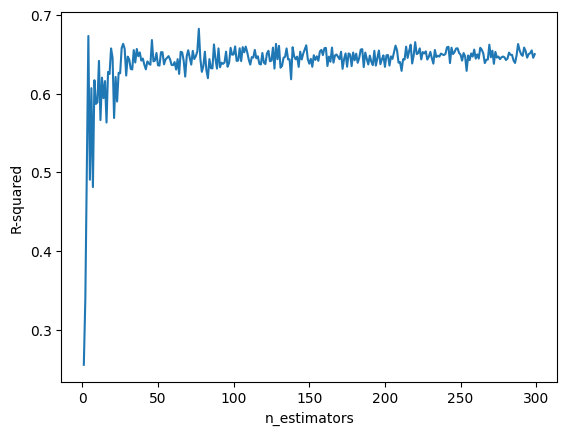

In [143]:
scores =[]
for i in range(1, 300):
    rand_forest = RandomForestRegressor(n_estimators=i)
    rand_forest.fit(x_train, y_train)
    y_pred = rand_forest.predict(x_test)
    scores.append(rand_forest.score(x_test, y_test))

plt.plot(range(1, 300), scores)
plt.xlabel('n_estimators')
plt.ylabel('R-squared')

In [60]:
rand_forest = RandomForestRegressor(n_estimators=150, random_state=21)

# Train the model on the training data
rand_forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=21)

In [62]:
y_pred = rand_forest.predict(x_test)

In [63]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.6452868075132084
R-squared: 0.6569493993100737


In [64]:
importances = rand_forest.feature_importances_

# Print the feature importances alongside the feature names
for feature, importance in zip(x_train.columns, importances):
    print(f'{feature}: {importance}')

EXPINF1YR: 0.1260162088534421
UNEMPLOY_GAP: 0.1400847888180068
POILAPSPUSDM_PC1: 0.4704787085321627
RBUSBIS_PC1: 0.2634202937963885


In [67]:
print((rand_forest))

RandomForestRegressor(n_estimators=150, random_state=21)


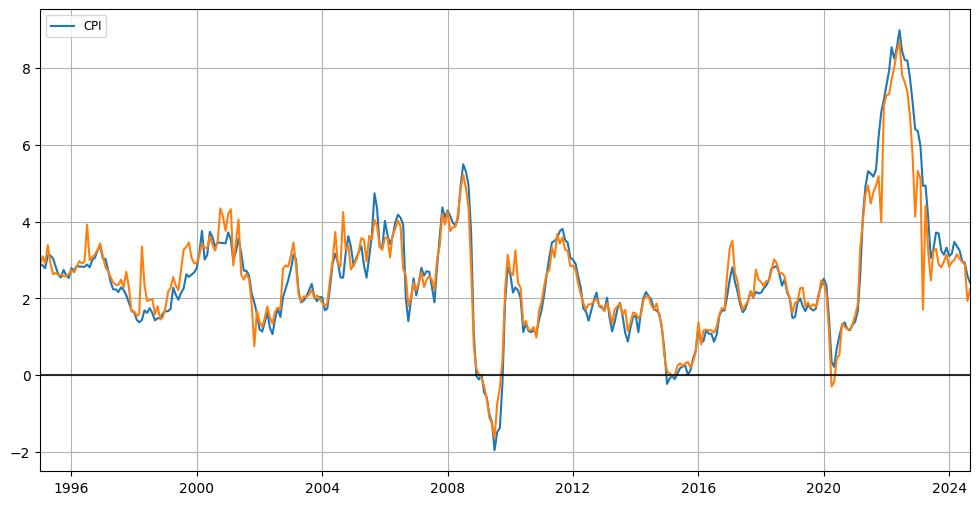

In [70]:
plt.figure(figsize=(12,6))
plt.plot(df.index,df['CPI'],label='CPI')
plt.plot(df.index,rand_forest.predict(df[['EXPINF1YR', 'UNEMPLOY_GAP', 'POILAPSPUSDM_PC1','RBUSBIS_PC1']]))

plt.axhline(y=-0.008, color='black',alpha=0.8)
plt.grid()
plt.legend(fontsize="small",loc="upper left")

plt.margins(x=0)
plt.show()

Linear models seem to struggle to obtain a high R-squared value but more importantly follow the overall trends in inflation. Here we see that the random forest model is far better in these regards. Perhaps a future project would be to derive a non-linear formula that both supports economic theory and matches the real world data.